<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/UNet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'finding-lungs-in-ct-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1172%2F2106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T130307Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a36bb51088a2ec4fe5d14b1c3ed4a953391a44c4985220a877ef4d2a8951f445e53dd0fd6b5dd200b9a5a27eca9cf8aeb1deb347cbd3b741d78a3bd067557a242ca47e6cffdd6ba05b9996e0a54f3cc8d92e303d8a108b6e3e9038c81f8b8c319ab786ed3a954919345c23ebed965dc30a10110173617825369b3c18ae1e106e6b48dfeb908731b4ff489533e95e52a68cdeff3db6afafce2c1d35b5a6d257dc65ee6b70f99fd7409c27a30857a045c93ccd3a9bf748ef4d79b05faccda75b8956eacc371fddade689b88b3dc7530ec6a75358572e202cc32d696a2fa668934784a96348b2c68c1f4930e5c14aac35f83401f06a777fb88af1bddbccbc66a0f,sarscov2-ctscan-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F615374%2F1199870%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T130307Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D365af1c72b46c22e69dee1331cac374a639988a6ccbb0ba549da9165ac45ec85c4c483c7035cf6cb1d359719bbaf9c963c45b7d4f954075d811c26dcc71c5da1bcae9e14d1bcd8ead9b7e43deb4ca1a10f23a2c4bc16ba594158c077c131c458ea4c65a1ba0d72bb1a89230e6912de0fc7469144ed6b51475b7c5401be181a08f352aa83b5af2ede96a69914e8554863505572ec34af60310a628d3173cfe0682e1ff6eec407b68020870e1a9b4ceafe7ddc0778bac17f97c8359a32b561e8444e6dffe121005b4a46046923fae6a710b3bee51838ee07fa2ea2486274c432fc5a30d354c16b760ac6bdd1096f792ec25634126940c355dcf5fc727de16c3037'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1108422436 bytes downloaded
Downloaded and uncompressed: finding-lungs-in-ct-data
[==================================================] 241684146 bytes downloaded
Downloaded and uncompressed: sarscov2-ctscan-dataset
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1064).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (595).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (225).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (998).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (543).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (605).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1109).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1150).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (925).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (515).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (958).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1136).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (478).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (581).png
/kaggle/input/sarscov2-ctscan-dataset/non-CO

In [ ]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=a795dc4a37f472643448d3228d3424e951635604743909b7de5025b15b00236b
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, RMSprop

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
import os
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob    # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
from skimage.util import montage
from skimage.io   import imread
%matplotlib inline

# Locate all the image and mask files

In [ ]:
BASE_IMG_PATH = os.path.join('..','input/finding-lungs-in-ct-data/')
DS_FACT = 2
SEED=42

all_image_files = glob(os.path.join(BASE_IMG_PATH,'2d_images','*.tif'))
all_mask_files  = glob(os.path.join(BASE_IMG_PATH,'2d_masks','*.tif'))

print('No. of images:', len(all_image_files))
print(all_image_files[0])
print(all_mask_files[0])

No. of images: 267
../input/finding-lungs-in-ct-data/2d_images/ID_0220_Z_0066.tif
../input/finding-lungs-in-ct-data/2d_masks/ID_0220_Z_0066.tif


# Load an image and check it out ...

(1, 256, 256)


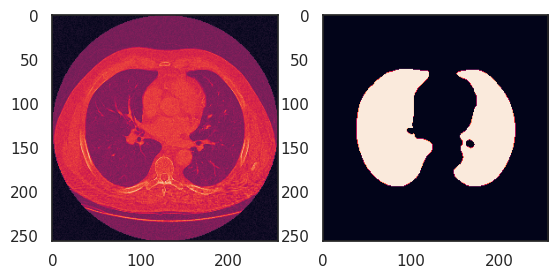

In [ ]:
test_image = np.expand_dims(imread(all_image_files[0])[::2, ::2],0)
test_mask  = np.expand_dims(imread(all_mask_files[0])[::2, ::2],0)/255.0
fig, (ax1 ,ax2) = plt.subplots(1, 2)
ax1.imshow(test_image[0])
ax2.imshow(test_mask[0])
print(test_image.shape)

Load all the images and masks

In [ ]:
#images  = np.stack((np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT], -1) for i in all_image_files),0)
#masks   = np.stack((np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT]/255., -1) for i in all_mask_files),0)

images = np.stack([np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT], -1) for i in all_image_files], axis=0)
masks = np.stack([np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT]/255., -1) for i in all_mask_files], axis=0)

X_train, X_test, y_train,  y_test = train_test_split(images, masks, test_size=0.1)

print('X_train - len/shape:', len(X_train), X_train.shape)
print('Y_train is {}, min is {}, max is {}, mean is {}'.format(y_train.shape, y_train.min(), y_train.max(), y_train.mean()))
print('X_test  - len/shape:', len(X_test), y_test.shape)
print(images.shape[:])

X_train - len/shape: 240 (240, 256, 256, 1)
Y_train is (240, 256, 256, 1), min is 0.0, max is 1.0, mean is 0.23422107696533204
X_test  - len/shape: 27 (27, 256, 256, 1)
(267, 256, 256, 1)


# Define the UNET

In [ ]:
def unet(inputs, n=32):
    bn    = BatchNormalization()(inputs)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bn)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)

    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

    up6   = Conv2DTranspose(n*8, (2, 2), strides=(2, 2), padding='same')(convm)
    conv6 = concatenate([up6, conv4])
    conv6 = Dropout(0.1)(conv6)
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7   = Conv2DTranspose(n*4, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = concatenate([up7, conv3])
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8   = Conv2DTranspose(n*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    conv8 = concatenate([up8, conv2])
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9   = Conv2DTranspose(n, (2, 2), strides=(2, 2), padding='same')(conv8)
    conv9 = concatenate([up9, conv1])
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[output])

# Define the model

In [ ]:

input_img = Input(X_train.shape[1:], name='img')
n_filters   = 32

model = unet(input_img, n_filters)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 1)          4         ['img[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']          

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lung.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [ ]:
history = model.fit(X_train, y_train, batch_size=10, epochs=24, callbacks=callbacks, \
                    validation_data=(X_test, y_test))

Epoch 1/24
24/24 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.7765
Epoch 1: val_loss improved from inf to 3.93004, saving model to model-lung.h5
24/24 [==============================] - 37s 493ms/step - loss: 0.5040 - accuracy: 0.7765 - val_loss: 3.9300 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 2/24
24/24 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8041
Epoch 2: val_loss improved from 3.93004 to 1.00389, saving model to model-lung.h5
24/24 [==============================] - 6s 251ms/step - loss: 0.3422 - accuracy: 0.8041 - val_loss: 1.0039 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 3/24
24/24 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8751
Epoch 3: val_loss improved from 1.00389 to 0.73278, saving model to model-lung.h5
24/24 [==============================] - 6s 247ms/step - loss: 0.3203 - accuracy: 0.8751 - val_loss: 0.7328 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 4/24
24/24 [=========================

The validation loss is 0.0267

# Evaluation

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

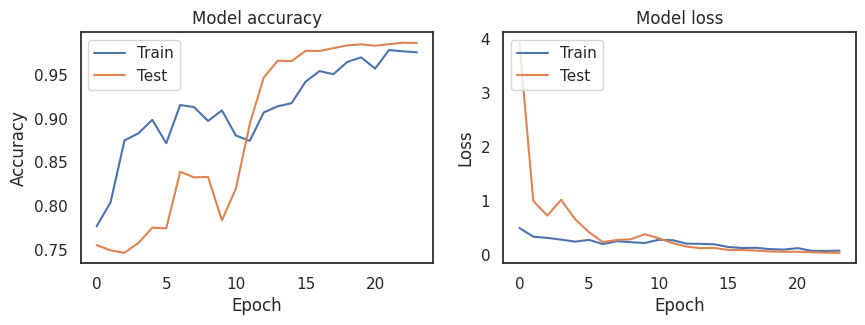

In [ ]:
plot_history(history, 'UNet Loss/Accuracy')

In [ ]:
model.load_weights('model-lung.h5')

1/1 [==============================] - 2s 2s/step


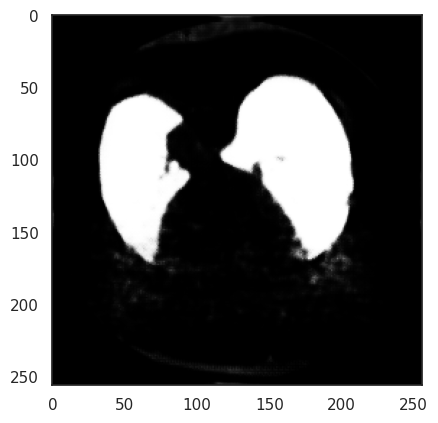

In [ ]:
plt.imshow(
    model.predict(X_train[0].reshape(1,256, 256, 1))[0,:,:,0],
    cmap='gray')

# Show the predictions of all 27 validation cases

1/1 [==============================] - 8s 8s/step


<ipython-input-26-74f4d9186fe0>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3,figsize=(12,6))


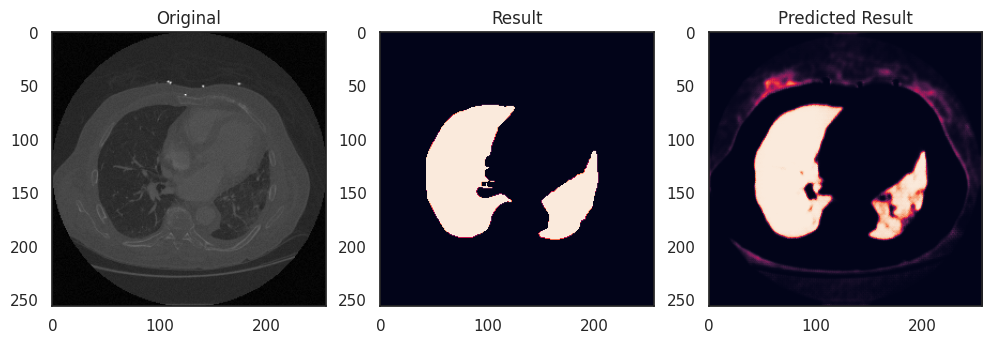

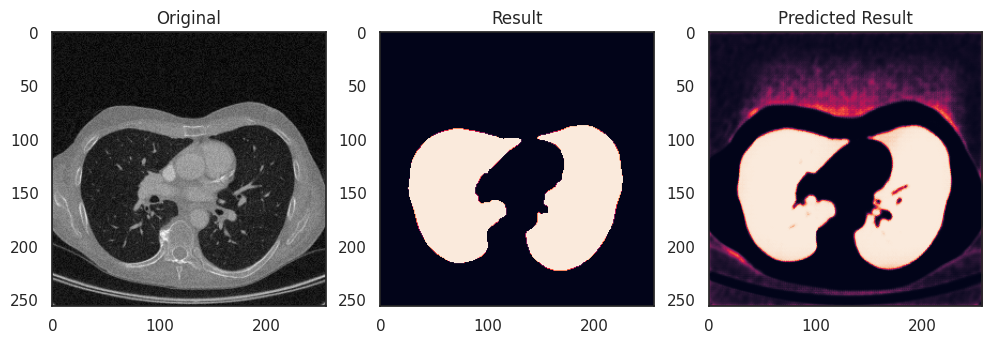

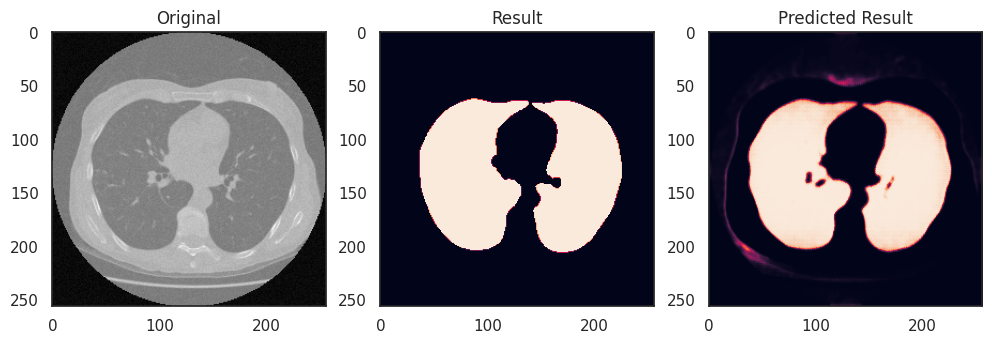

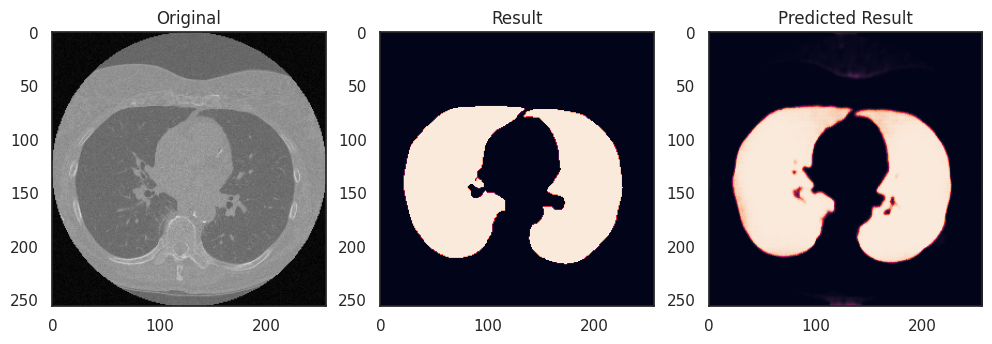

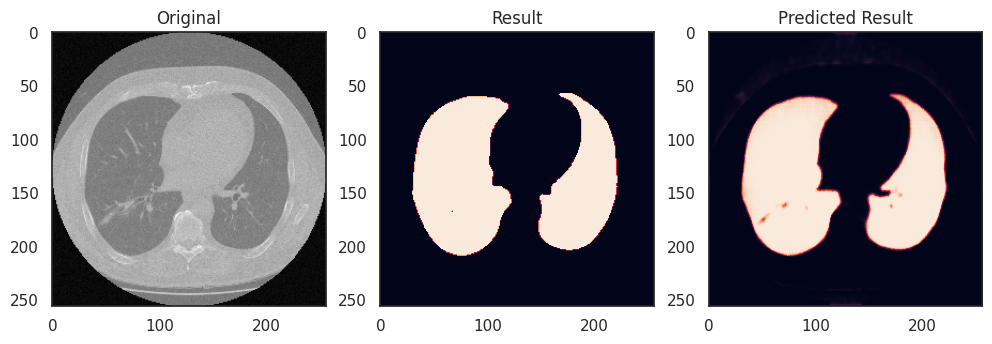

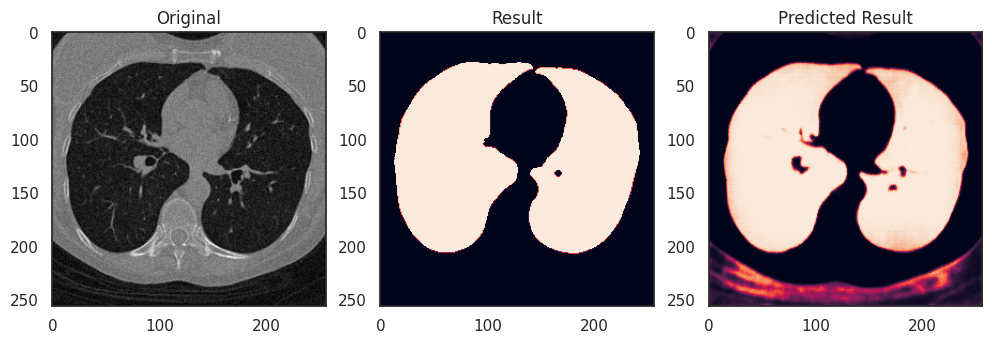

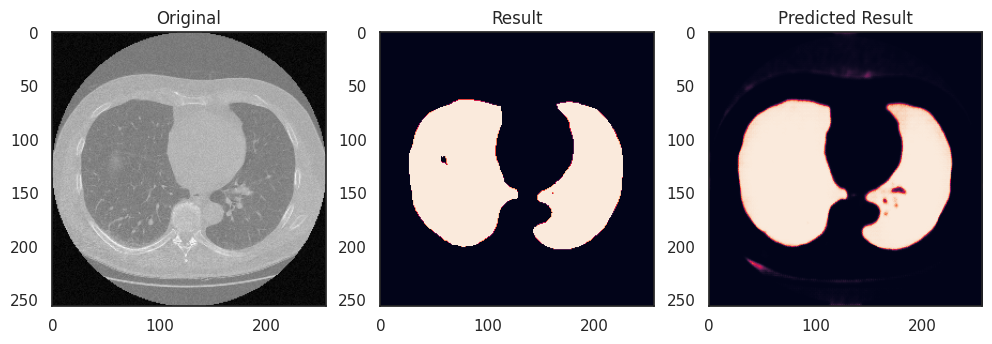

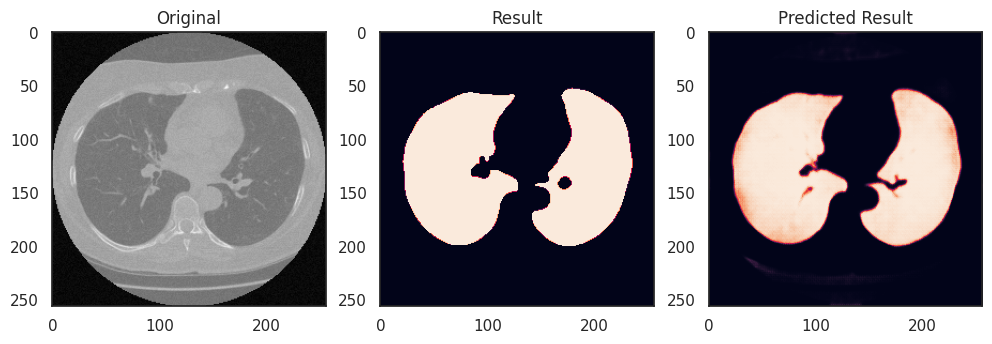

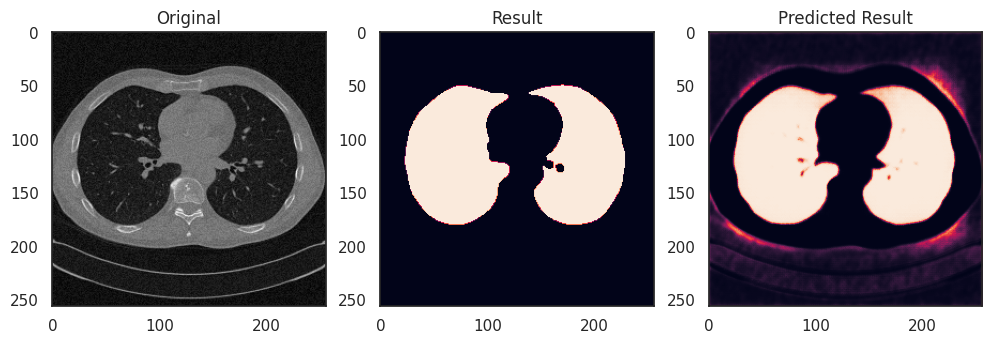

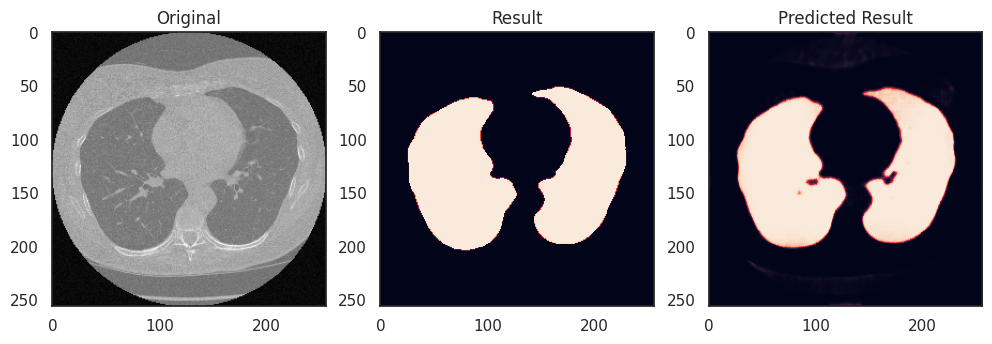

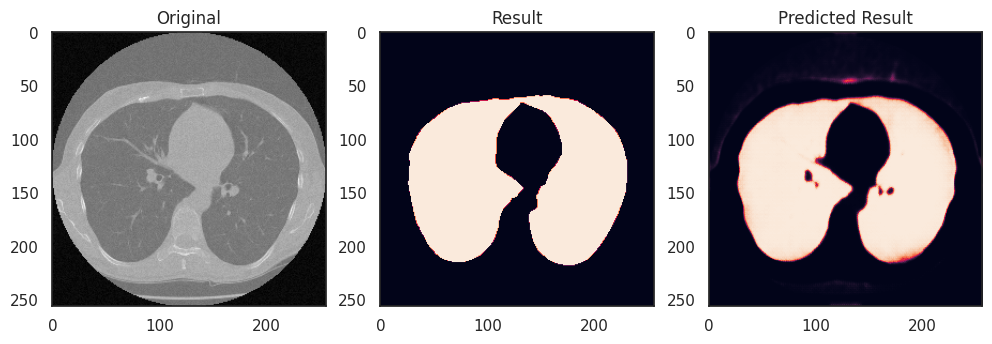

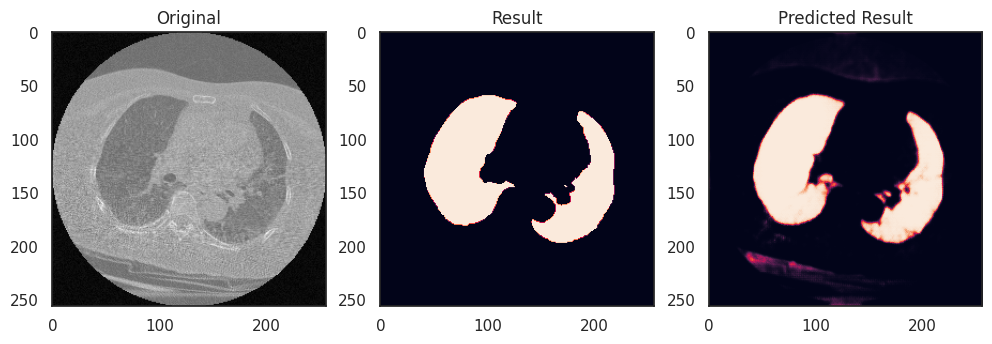

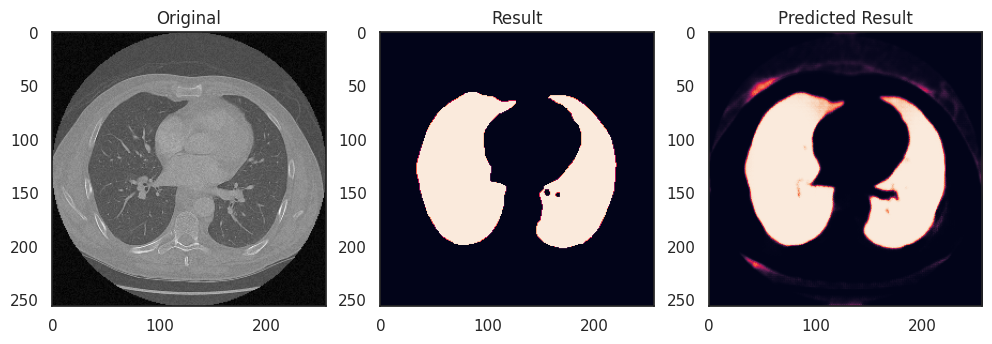

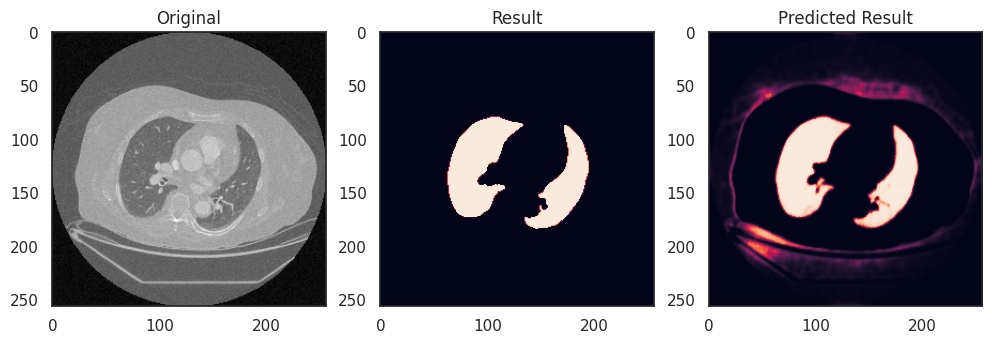

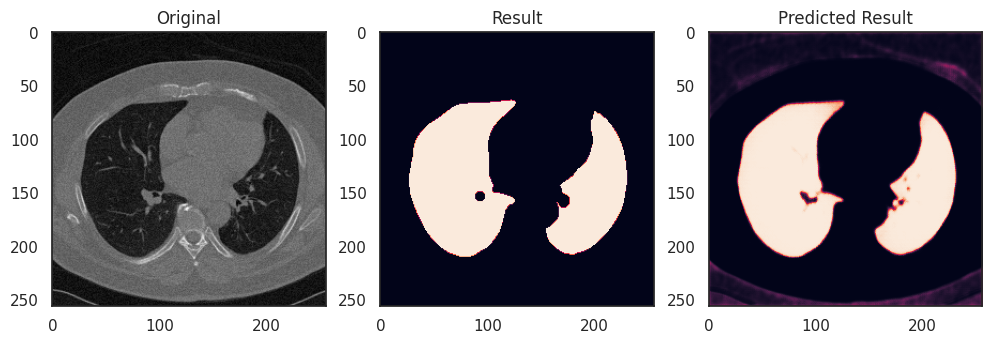

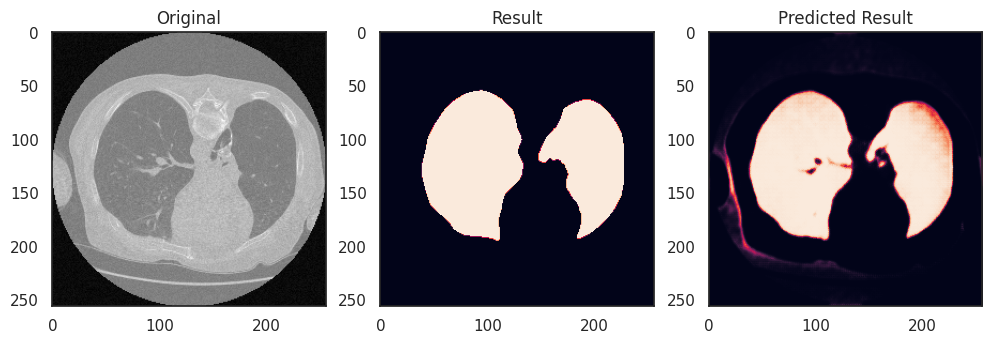

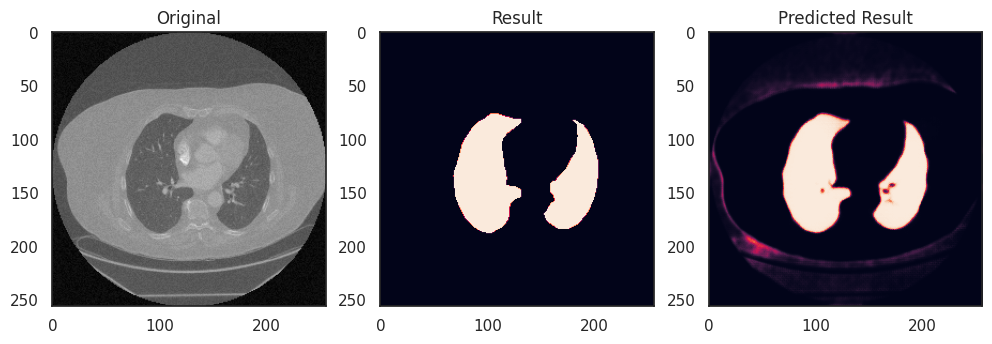

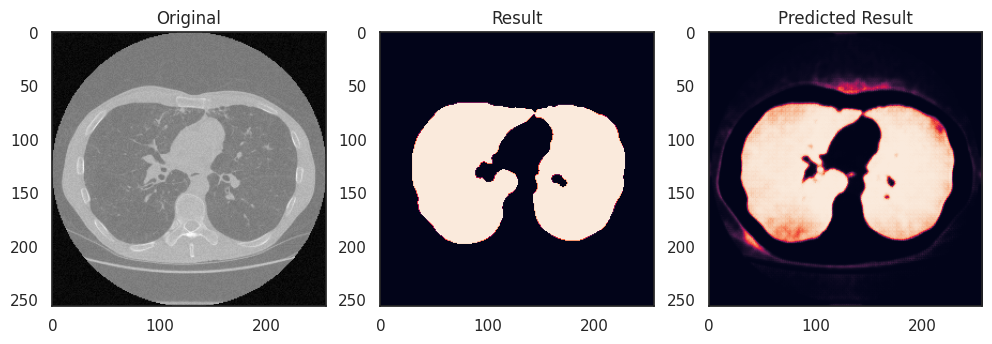

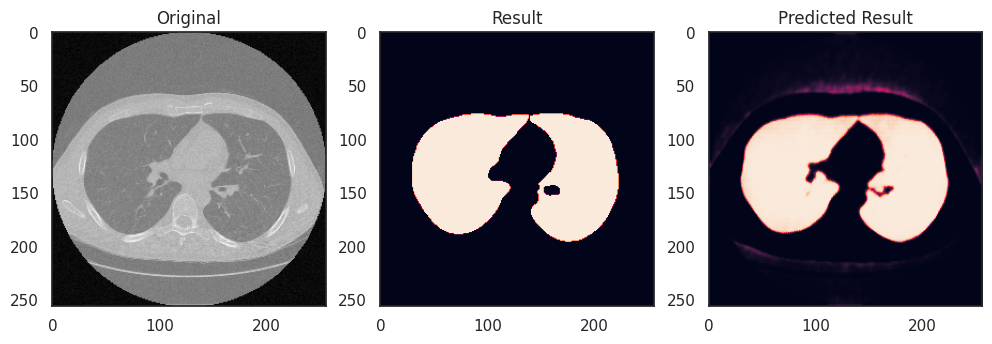

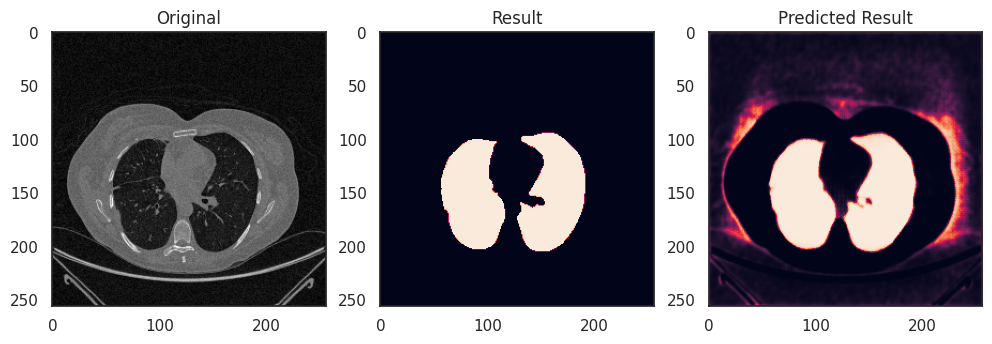

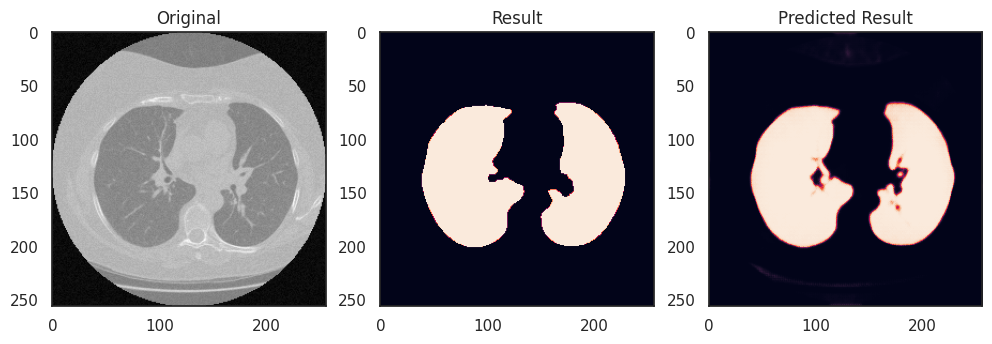

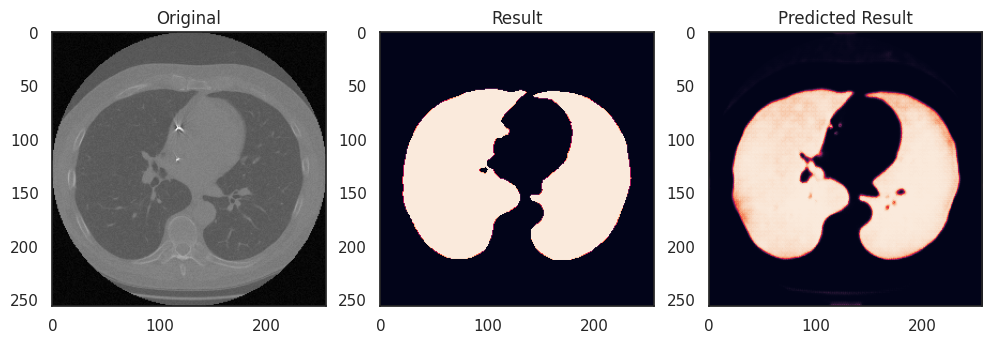

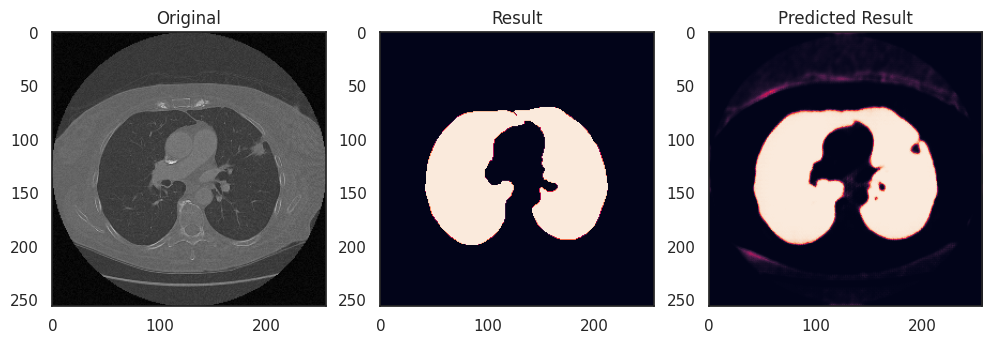

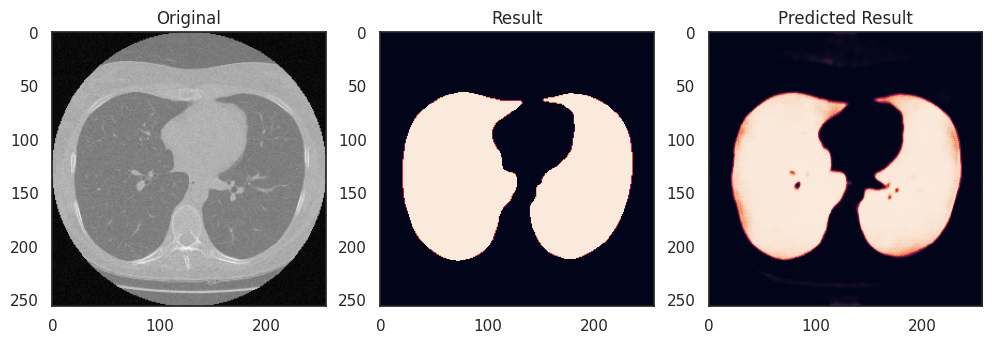

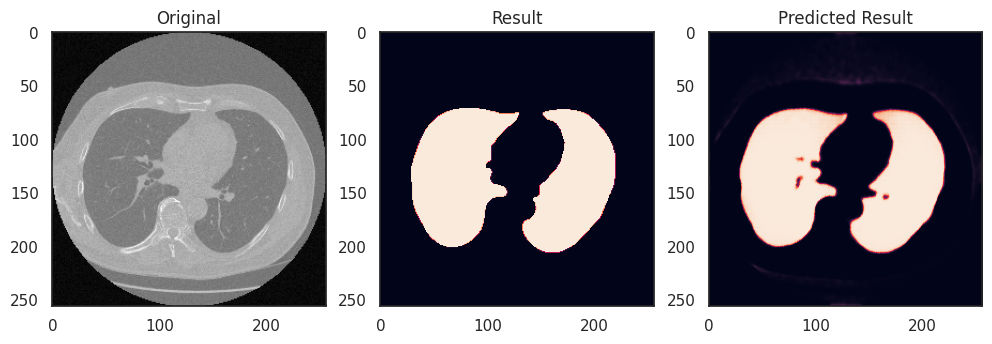

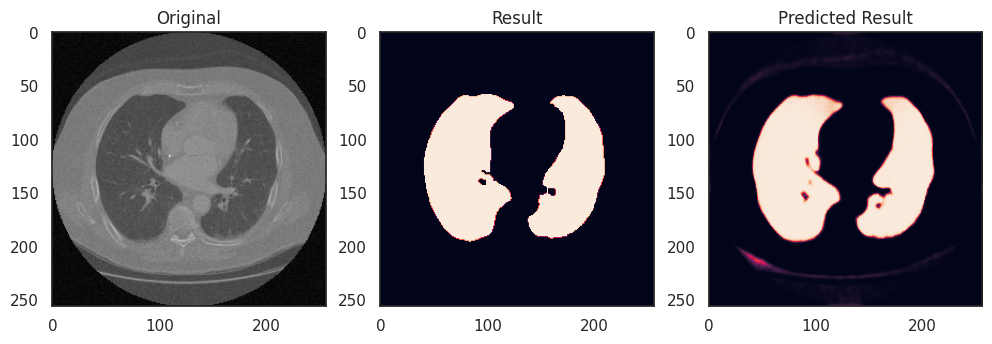

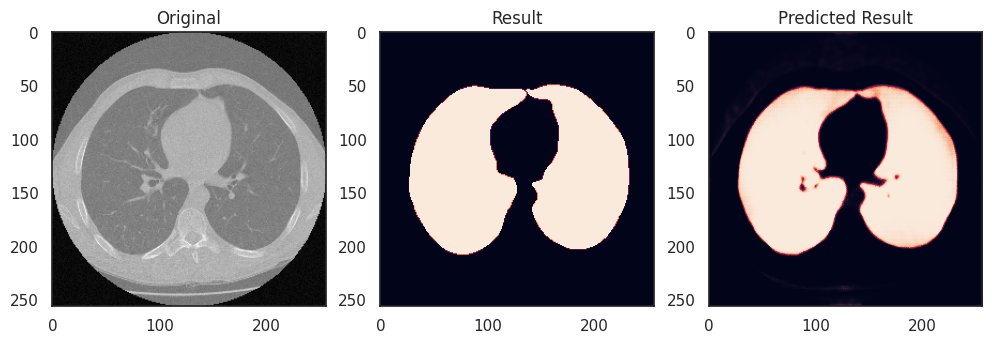

In [ ]:
y_predict = model.predict(X_test)

for i in range(X_test.shape[0]):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].set_title('Original')
    ax[1].set_title('Result')
    ax[2].set_title('Predicted Result')
    ax[0].imshow(X_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0])
    ax[2].imshow(y_predict[i,:,:,0])